In [6]:
## This file provides starter code for extracting features from the xml files and
## for doing some learning.
##
## The basic set-up:
## ----------------
## main() will run code to extract features, learn, and make predictions.
##
## extract_feats() is called by main(), and it will iterate through the
## train/test directories and parse each xml file into an xml.etree.ElementTree,
## which is a standard python object used to represent an xml file in memory.
## (More information about xml.etree.ElementTree objects can be found here:
## http://docs.python.org/2/library/xml.etree.elementtree.html
## and here: http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/)
## It will then use a series of "feature-functions" that you will write/modify
## in order to extract dictionaries of features from each ElementTree object.
## Finally, it will produce an N x D sparse design matrix containing the union
## of the features contained in the dictionaries produced by your "feature-functions."
## This matrix can then be plugged into your learning algorithm.
##
## The learning and prediction parts of main() are largely left to you, though
## it does contain code that randomly picks class-specific weights and predicts
## the class with the weights that give the highest score. If your prediction
## algorithm involves class-specific weights, you should, of course, learn
## these class-specific weights in a more intelligent way.
##
## Feature-functions:
## --------------------
## "feature-functions" are functions that take an ElementTree object representing
## an xml file (which contains, among other things, the sequence of system calls a
## piece of potential malware has made), and returns a dictionary mapping feature names to
## their respective numeric values.
## For instance, a simple feature-function might map a system call history to the
## dictionary {'first_call-load_image': 1}. This is a boolean feature indicating
## whether the first system call made by the executable was 'load_image'.
## Real-valued or count-based features can of course also be defined in this way.
## Because this feature-function will be run over ElementTree objects for each
## software execution history instance, we will have the (different)
## feature values of this feature for each history, and these values will make up
## one of the columns in our final design matrix.
## Of course, multiple features can be defined within a single dictionary, and in
## the end all the dictionaries returned by feature functions (for a particular
## training example) will be unioned, so we can collect all the feature values
## associated with that particular instance.
##
## Two example feature-functions, first_last_system_call_feats() and
## system_call_count_feats(), are defined below.
## The first of these functions indicates what the first and last system-calls
## made by an executable are, and the second records the total number of system
## calls made by an executable.
##
## What you need to do:
## --------------------
## 1. Write new feature-functions (or modify the example feature-functions) to
## extract useful features for this prediction task.
## 2. Implement an algorithm to learn from the design matrix produced, and to
## make predictions on unseen data. Naive code for these two steps is provided
## below, and marked by TODOs.
##
## Computational Caveat
## --------------------
## Because the biggest of any of the xml files is only around 35MB, the code below
## will parse an entire xml file and store it in memory, compute features, and
## then get rid of it before parsing the next one. Storing the biggest of the files
## in memory should require at most 200MB or so, which should be no problem for
## reasonably modern laptops. If this is too much, however, you can lower the
## memory requirement by using ElementTree.iterparse(), which does parsing in
## a streaming way. See http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/
## for an example.

import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD as PCA
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


import pickle

from sklearn.gaussian_process.kernels import RBF
import util


def extract_feats(ffs, direc="train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that
      the columns of the test matrix align correctly.

    returns:
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order
      of their rows in the design matrix.

      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = []
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        fds.append(rowfd)

    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids


def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that
      the columns of the test matrix align correctly.

    returns:
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(fd.keys()) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict

    cols = []
    rows = []
    data = []
    for i in range(len(fds)):
        temp_cols = []
        temp_data = []
        for feat,val in fds[i].iteritems():
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)


    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict


## Here are two example feature-functions. They each take an xml.etree.ElementTree object,
# (i.e., the result of parsing an xml file) and returns a dictionary mapping
# feature-names to numeric values.
## TODO: modify these functions, and/or add new ones.
def first_last_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'first_call-x' to 1 if x was the first system call
      made, and 'last_call-y' to 1 if y was the last system call made.
      (in other words, it returns a dictionary indicating what the first and
      last system calls made by an executable were.)
    """
    c = Counter()
    in_all_section = False
    first = True # is this the first system call
    last_call = None # keep track of last call we've seen
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            if first:
                c["first_call-"+el.tag] = 1
                first = False
            last_call = el.tag  # update last call seen

    # finally, mark last call seen
    c["last_call-"+last_call] = 1
    return c

def system_call_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'num_system_calls' to the number of system_calls
      made by an executable (summed over all processes)
    """
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c['num_system_calls'] += 1
    return c

## Add Our Custom Functions Below

def system_call_termination_reason(tree):
    c = Counter()
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "process":
            c["termination_reason-"+el.attrib['terminationreason']] = 1
            c["executionstatus-"+el.attrib['executionstatus']] = 1
    return c

def system_call_count_feat_types(tree):
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        c['system_call-'+el.tag] += 1
    return c

def system_call_bigrams(tree):
    c = Counter()
    in_all_section = False
    prev = ""
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c['system_call_bigram-'+el.tag+prev] += 1
            prev = el.tag
    return c

def system_call_trigrams(tree):
    c = Counter()
    in_all_section = False
    prev = ""
    pre = ""
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c['system_call_bigram-'+pre+prev+el.tag] += 1
            pre = prev
            prev = el.tag
    return c

def system_call_processes(tree):
    c = Counter()
    for el in tree.iter():
        if el.tag == "process":
            if "startreason" in el.attrib and "terminationreason" in el.attrib:
                c['system_call_processes_startreason-'+el.attrib['startreason']] += 1
                c['system_call_processes_terminationreason-'+el.attrib['terminationreason']] += 1
    return c

def system_call_unsuccessful(tree):
    c = Counter()
    for el in tree.iter():
        if "successful" in el.attrib and el.attrib['successful'] == "0":
            c['system_call_unsuccessful-'+el.tag] += 1
    return c


priors = [3.69, 1.62, 1.20, 1.03, 1.33, 1.26, 1.72, 1.33, 52.14, 0.68, 17.56, 1.04, 12.18, 1.91, 1.30]

## The following function does the feature extraction, learning, and prediction

train_dir = "train"
test_dir = "test"
outputfile = "predictions3062019.csv"  # feel free to change this or take it as an argument

# TODO put the names of the feature functions you've defined above in this list
ffs = [system_call_termination_reason, system_call_bigrams, system_call_trigrams]
# ffs = [first_last_system_call_feats, system_call_count_feats, system_call_termination_reason, system_call_count_feat_types, system_call_processes, system_call_unsuccessful]
# ffs = [system_call_termination_reason]
# extract features



print("extracting training features...")
X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)
# print "\n\n\n"
# print len(global_feat_dict)
print("done extracting training features")
print
X_train, X_test, t_train, t_test = train_test_split(X_train, t_train, random_state = 1)
# pickle.dump( (X_train, X_test, t_train, t_test, global_feat_dict,t_train,train_ids), open( "save.p", "wb" ) )
print(len(global_feat_dict))

# TO


extracting training features...
done extracting training features

13096


learning...
(2314, 13096)
done with n_classifiers = 1, score = 0.678756
done with n_classifiers = 2, score = 0.777202
done with n_classifiers = 3, score = 0.788860
done with n_classifiers = 4, score = 0.809585
done with n_classifiers = 5, score = 0.821244
done with n_classifiers = 6, score = 0.844560


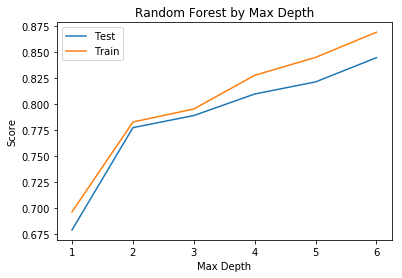

In [27]:
import matplotlib.pyplot as plt
#DO train here, and learn your classification parameters
print("learning...")
print(X_train.shape)
scores = []
scores2 = []
x_axis = [1,2,3,4,5,6]
for n in x_axis:
    clf = RandomForestClassifier(n_estimators = 25, max_depth = n, random_state=4)
    clf.fit(X_train,t_train)
    sc = clf.score(X_test, t_test)
    scores.append(sc)
    scores2.append(clf.score(X_train, t_train))
    print "done with n_classifiers = %i, score = %f" % (n, sc)

plt.plot(x_axis, scores, x_axis, scores2, '-')
plt.title('Random Forest by Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.legend(['Test', 'Train'])

In [22]:
scores2

[0.986171132238548,
 0.9926534140017286,
 0.9926534140017286,
 0.9926534140017286,
 0.9926534140017286]

In [ ]:
#get rid of training data and load test data
del X_train
del t_train
del train_ids
print("extracting test features...")
X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)
print("done extracting test features")
print

# TODO make predictions on text data and write them out
print("making predictions...")
preds = clf.predict((X_test))
print ("done making predictions")
print

print ("writing predictions...")
util.write_predictions(preds, test_ids, outputfile)
print ("done!")
